# About
This notebook contains the experiment that aims to recognize the best MVI strategy to imput missing data. The criteria to decide the best method would be after doing a residual analysis between imputed data and real measurements. In this experiment, univariate and multivariate methods are used, where the variables are each monitoring station and the returning objects can be also multivariate. But for practicity, only the imputed time series data from the Obispado (CE) monitoring station for the PM2.5 measurement will be analyzed. This station has the most real data, so it would provide more information for the residual analysis. 

# Libraries

In [1]:
%run "../main_global.ipynb"

Connection with MySQL database is ready!


In [2]:
%run "../main_mvi.ipynb"

Functions for MVI Processes are ready!


In [3]:
import matplotlib.pyplot as plt
from numpy import arange, argwhere, isnan, array, sum, abs

In [4]:
import random
random.seed(101)

# User-Defined Functions

In [5]:
def stations_empty_values(raw_list = raw_table_list()):
    results = empty_df_measurement_station()
    
    for table_name in raw_list:
        
        # Read raw dataset
        sqlq = "SELECT * FROM {}".format(table_name)
        
        # Reformat table
        raw_df = reindex_aq_table(qdata(sqlq))
        
        # Count NaN values 
        nulls_count = count_nulls(raw_df, table_name)        
        results = results.append(nulls_count)
        
    return results

In [6]:
def plot_heatmap(data):
    
    column_labels = list(data.index)
    row_labels = list(data.columns)

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(results.astype("float32"), cmap = 'coolwarm')

    ax.set_xticks(arange(len(row_labels)))
    ax.set_yticks(arange(len(column_labels)))

    # Want a more natural, table-like display
    #ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(row_labels, rotation=90)
    ax.set_yticklabels(column_labels)

    #ax.set_horizontalalignment('center')

    plt.show()    

In [7]:
def index_to_drop(drop_pctge = .1, station = "ce"):
    station = station.lower()
    sqlq = "Select datetime, {} from sima_pm25".format(station)
    data = qdata(sqlq).set_index("datetime")
    
    
    missing_vals = data[data[station] == 0]
    available_vals = data[data[station] != 0]
    print("Original percentage of missing data: {:.2f}%".format(len(missing_vals) / len(data) * 100))
    
    index_drop = random.sample(list(available_vals.index), int(len(available_vals) * drop_pctge))    
    original = data.loc[index_drop].copy()
    data.loc[index_drop] = 0
    
    missing_vals = data[data[station] == 0]
    print("New Percentage of missing data: {:.2f}%".format(len(missing_vals) / len(data) * 100))
    
    return original, index_drop

In [8]:
def exp_mvi_mean(sqlq, index_drop):
    
    mvi_data = qdata(sqlq).set_index("datetime")
    mvi_data.loc[index_drop] = 0
    
    out = mvi_mean(mvi_data)
    
    return out

In [9]:
def exp_mvi_sa(sqlq, index_drop, station = "CE"):    
    mvi_data = qdata(sqlq).set_index("datetime")
    mvi_data[station].loc[index_drop] = 0
    
    out = mvi_spatialAvg(mvi_data)
    
    return out

In [10]:
def exp_mvi_mice(sqlq, index_drop, station = "CE"):    
    mvi_data = qdata(sqlq).set_index("datetime")
    mvi_data[station].loc[index_drop] = 0
    
    out = mvi_MICE(mvi_data)
    
    return out

# Main

## > Overview of missing data from every monitoring station
The raw datasets generated by the monitoring stations in the MMA define missing values with a numerical zero. 
A heatmap was created to understand beforehand the distribution of zeros throughout every dataset in the database.

The resulting heatmap is shown in Figure \figure{}. 

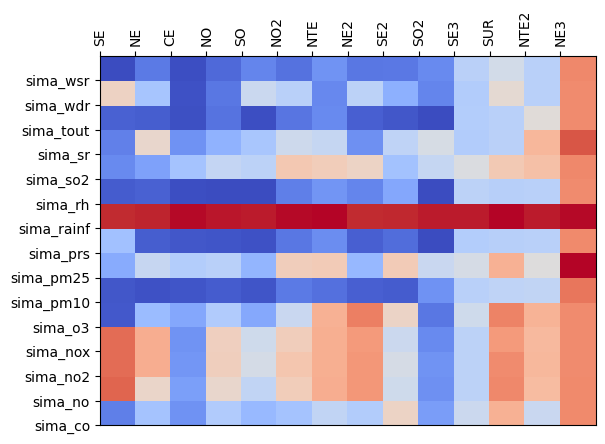

In [11]:
results = stations_empty_values()
plot_heatmap(results)

This heatmap takes as input a dataframe object with the counts of zero values for each dataset (rows) and each monitoring station (columns). It uses a colormap from blue to red where the higher intensity of red means the more missing values in that location. Since all the features in each dataset are all numerical values, it is confusing it these zero-values are actual measurements. For the case of the `sima_rainf` dataset, this would mean that throughout those years there has been a noticeable lack of rainfall that has left the capital with scarce levels of water. In a report by [Mongabay](https://news.mongabay.com/2022/08/climate-change-hits-northern-mexico-as-officials-look-to-solve-water-crisis/), they argue that this lack of rainfall along with increasing heat, and the unsustainable deforestation and degradation of natural forests, led to the critical water shortage problem that was lived in the most part of the year 2022.

When rain happens, it considerably affects the levels of air pollution in the MMA. But the detailed information about how much rain has fallen is not needed to make air pollution forecasting. It would be useful if the time series data for the precipitation was continuous, but with a share of 98.86\% of missing data, it would mainly not be worth keeping in the analysis. Considering all this, the information from the `sima_rainf` dataset will be removed from the analysis for the forecasting models. 

Another insight from this heatmap is that the information from the NE3 monitoring station is very empty. This could mean that this monitoring station has not been functional for the majority of the time period than the other stations. Also, it was not identified from the official catalogue provided by SIMA. So, the information from this station is dropped.

A third insight is that we can recognize that the Obispado (CE) monitoring station has the least missing values time series data (i.e. it is the most complete). It is seconded by the San Pedro (SO2) monitoring station. Their respective values as percentages are respectively 20.68% and 25.08% of missing data. Or in other words, they are 79.32% and 74.92% complete.

Overall, and with a couple of exceptions, the meteorological measurements (i.e. prs, rainf, rh, tout, wdr, wsr) taken by the monitoring stations has less missing values compared to the atmospheric gases (i.e. co, no, no2, nox, o3). 

In [12]:
# Original table size for every monitoring station
sqlq = "SELECT COUNT(*) AS num_rows FROM {};".format(raw_table_list()[0])
table_size = aux_qdata(sqlq)[0][0]

print("Percentage of missing values for `rainf` throughout all monitoring stations {:.2f}%".format(results.loc["sima_rainf"].sum() / (table_size * 14) * 100))

Percentage of missing values for `rainf` throughout all monitoring stations 98.22%


In [13]:
print("Percentage of missing values for CE data: {:.2f}%".format(results["CE"].sum()  / (table_size * len(results.index)) * 100) )

Percentage of missing values for CE data: 20.68%


In [14]:
print("Percentage of missing values for SO2 data: {:.2f}%".format(results["SO2"].sum()  / (table_size * len(results.index)) * 100) )

Percentage of missing values for SO2 data: 25.08%


# MVI

## <*> Dates to take for residual analysis
To make a residual analysis, it is necessary to compare the imputed value with a real value. For the already missing data, it is not possible to compare it with its real value because that information doesn't exist. To do this, an additional number of observations will be dropped from the original raw dataset, then allow the MVI mehthod to impute the missing values including those newly created, and finally do the comparison. this will be done from the data measured by the Obispado (CE) monitoring station. This data drop can't be to big, so as to not affect considerably the MVI calculation. Considering this, only 10% from the Non-Missing data is dropped.

In [15]:
ce_data, index_drop = index_to_drop(0.1)

Original percentage of missing data: 37.27%
New Percentage of missing data: 43.54%


In [16]:
ce_data.loc[index_drop]

,ce
datetime,
2022-01-17 20:00:00,15.0
2018-07-28 05:00:00,27.0
2021-09-22 22:00:00,11.0
2020-01-31 14:00:00,70.0
2021-02-06 12:00:00,54.0
...,...
2020-04-14 12:00:00,45.0
2018-12-27 11:00:00,25.0
2019-07-29 02:00:00,11.0


## > Mean

In [17]:
sqlq = "Select datetime, ce from sima_pm25"
mvi_mean = exp_mvi_mean(sqlq, index_drop)

In [18]:
mvi_mean.loc[index_drop]

,ce
datetime,
2022-01-17 20:00:00,23.64065
2018-07-28 05:00:00,23.64065
2021-09-22 22:00:00,23.64065
2020-01-31 14:00:00,23.64065
2021-02-06 12:00:00,23.64065
...,...
2020-04-14 12:00:00,23.64065
2018-12-27 11:00:00,23.64065
2019-07-29 02:00:00,23.64065


## > Spatial Average

In [19]:
sqlq = "Select * from sima_pm25"
mvi_sa = exp_mvi_sa(sqlq, index_drop)

In [20]:
mvi_sa["CE"].loc[index_drop]

datetime
2022-01-17 20:00:00    15.000000
2018-07-28 05:00:00    27.285714
2021-09-22 22:00:00    16.300000
2020-01-31 14:00:00    47.181818
2021-02-06 12:00:00    35.600000
                         ...    
2020-04-14 12:00:00    14.750000
2018-12-27 11:00:00    13.454545
2019-07-29 02:00:00    11.700000
2015-08-20 09:00:00    23.333333
2015-02-19 20:00:00    18.333333
Name: CE, Length: 4010, dtype: float64

## > Multiple imputation by chained equations (MICE)

In [21]:
sqlq = "Select * from sima_pm25"
mvi_mice = exp_mvi_mice(sqlq, index_drop)

In [22]:
mvi_mice["CE"].loc[index_drop]

datetime
2022-01-17 20:00:00    13.352779
2018-07-28 05:00:00    27.492087
2021-09-22 22:00:00     8.741853
2020-01-31 14:00:00    48.736504
2021-02-06 12:00:00    55.255241
                         ...    
2020-04-14 12:00:00    19.783234
2018-12-27 11:00:00    11.468582
2019-07-29 02:00:00    12.809752
2015-08-20 09:00:00    23.305539
2015-02-19 20:00:00    16.429979
Name: CE, Length: 4010, dtype: float64

# Residual Analysis

In [23]:
y_true = ce_data["ce"].loc[index_drop].values

## > MAE

In [25]:
from sklearn.metrics import mean_absolute_error

In [26]:
# MVI Mean
y_pred = mvi_mean["ce"].loc[index_drop].values
mean_absolute_error(y_true, y_pred)

11.566782480854595

In [27]:
# MVI Spatial Average
y_pred = mvi_sa["CE"].loc[index_drop].values
y_pred[[i[0] for i in argwhere(isnan(y_pred))]] = 0.0
mean_absolute_error(y_true, y_pred)

8.246059542521763

In [28]:
# MVI MICE
y_pred = mvi_mice["CE"].loc[index_drop].values
mean_absolute_error(y_true, y_pred)

7.440977150567713

MICE Without removing negative values:
7.447515139146674

## > sMAPE

In [29]:
def smape(t, p):
    """
    t: true value
    p: predicted value
    """
    t = array(t)
    p = array(p)
    
    num =  abs(p-t)
    den =  (abs(t) + abs(p)) / 2
    
    return 1/len(t) * sum(num / den) * 100 

In [30]:
# MVI Mean
y_pred = mvi_mean["ce"].loc[index_drop].values
smape(y_true, y_pred)

49.56698670502486

In [31]:
# MVI Spatial Average
y_pred = mvi_sa["CE"].loc[index_drop].values
y_pred[[i[0] for i in argwhere(isnan(y_pred))]] = 0.0
smape(y_true, y_pred)

36.09950354050872

In [32]:
# MVI MICE
y_pred = mvi_mice["CE"].loc[index_drop].values
smape(y_true, y_pred)

33.30496780497904

MICE Without removing negative values:
    33.40082705794553

# Discussion
After processing the data with multiple MVI methods, a particular case of interest happened. Starting with the Spatial Average method, there was the case where only the Obispado monitoring station had information while the other stations didn't have any. Since this method averages all the observations from each time step, and the CE station was removed for the residual analysis test, there was nothing to average and returned an empty value, which would affect the residual analysis. These values had to be transformed to zeroes to proceed with the residual analysis, otherwise the time series data would not be contiguous. Training with inconsistent data would complicate the data modeling stage and return worse performance metrics.

There was also a problem with the MICE procedure in which it generated negative values. A negative value is not possible for any of the variables in the dataset. So, a procedure was implemented to replace any negative value from each variable with its corresponding real minimum greater than zero. This value was taken from the unprocessed data (i.e. original data). By doing so, the performance metrics for both the MAE and sMAPE impoved marginally from 7.4475 to 7.4409 for the MAE and from 33.400 to 33.304 for the sMAPE. 

# Conclusions
Using the MAE and sMAPE metrics, a hierarchy of performance was defined. With the best results was the MICE method, followed by the Spatial Average, and finally the mean. MICE had a MAE performance of 7.45 and a sMAPE performance of 33.40. 